In [11]:
!pip install geopandas
!pip install rasterio
!pip install numpy
!pip install contextily

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import contextily as cx

In [13]:
# Major LA County Transit Stops
major_transit_stops_la = gpd.read_file("../../data/preprocessed/la_major_transit_stops_dtla.geojson")
major_transit_stops_la.head()

,OBJECTID,stop_id,route_count,route_stop,lat,lon,geometry
0,980,19230,5,"MT078, MT014, MT076, MT033, MT070",34.035211,-118.265408,POINT (-118.26541 34.03521)
1,981,19305,3,"MT078, MT076, MT070",34.036571,-118.264287,POINT (-118.26429 34.03657)
2,982,19363,4,"MT078, MT014, MT076, MT070",34.038288,-118.263289,POINT (-118.26329 34.03829)
3,983,19432,3,"MT078, MT076, MT070",34.040865,-118.260884,POINT (-118.26088 34.04087)
4,984,19475,5,"MT078, MT014, FZ707, MT076, MT070",34.042313,-118.259532,POINT (-118.25953 34.04231)


In [14]:
major_transit_stops_la = major_transit_stops_la.to_crs(epsg=3857)

ucla_shade = gpd.read_file("../../data/preprocessed/ucla_shade_mapping_dtla.geojson")
print(f"UCLA Shade CRS: {ucla_shade.crs}")

# Now that we see it isn't in the right projection we can convert it to the standard Web Mercator Projection
shade_reprojected = ucla_shade.to_crs("EPSG:3857")
print(f"Corrected Shade CRS: {shade_reprojected.crs}")

UCLA Shade CRS: EPSG:4326
Corrected Shade CRS: EPSG:3857


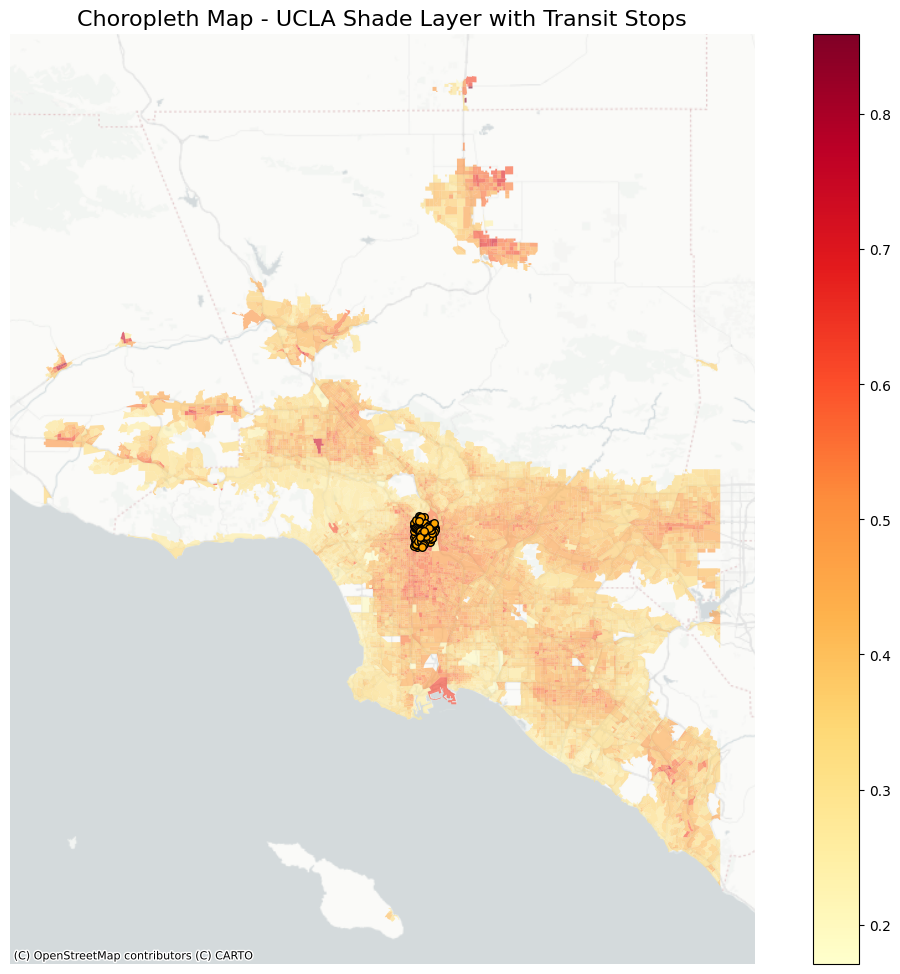

In [15]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Determine target column to plot (priority_i, tree_canopy)
target_variable = 'priority_i'

# Plot UCLA Shade layer as a choropleth
shade_reprojected.plot(
    ax=ax,
    column=target_variable,
    cmap='YlOrRd',
    legend=True,
    alpha=0.6  # slightly transparent so basemap shows through
)

# Plot bus stops in purple
# bus_stops.plot(ax=ax, color='purple', markersize=3, alpha=0.6, zorder=2)

# Plot major DTLA transit stops in orange
major_transit_stops_la.plot(ax=ax, color='orange', markersize=30, edgecolor='black', zorder=3)

# Add LA basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels)

# Title and labels
ax.set_title('Choropleth Map - UCLA Shade Layer with Transit Stops', fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

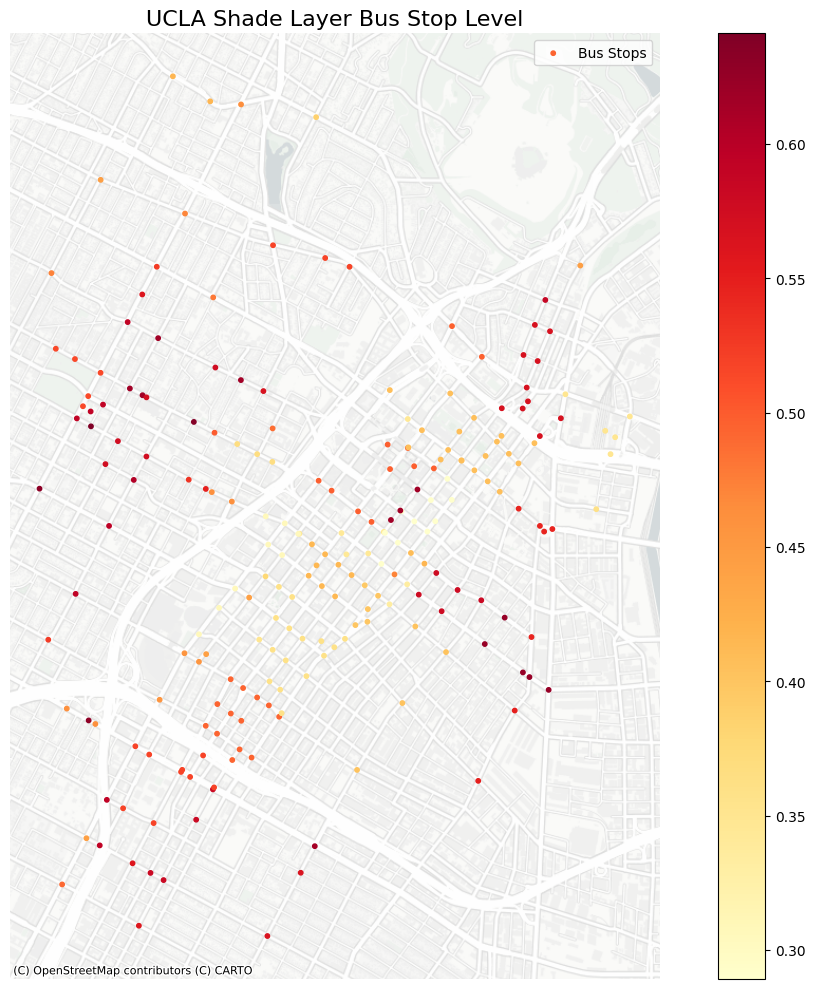

In [16]:
# This will do a join on all the bus stops with the polygon layers based on the intersection (the predicate)

bus_stops_shade = gpd.sjoin(major_transit_stops_la, shade_reprojected, how = 'left') # make sure you join dataframes that are in the same projection

# Now we can visualize the excess number of er visits by bus stops, although since the aggregation 
# is a the zip code level, there won't be much variation

fig, ax = plt.subplots(figsize = (12, 10))

bus_stops_shade.plot(ax = ax, label = "Bus Stops", column = target_variable,cmap='YlOrRd', markersize = 10, legend = True)

# For this map let's turn off the axis and add LA as the background map
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = bus_stops_shade.crs)
# if you are interested in more background/basemaps you can see the full list with the command cx.providers

ax.set_axis_off()
ax.set_title('UCLA Shade Layer Bus Stop Level', fontsize=16)


ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.legend()
plt.show()

In [18]:
shade_reprojected["heat_layer"] = (
    shade_reprojected.get("temp_diff", 0) +
    (1 - shade_reprojected.get("treecanopy", 0)) +
    shade_reprojected.get("tc_gap", 0)
)

shade_reprojected["socioeconomic_layer"] = (
    shade_reprojected["pctpocnorm"]
    + shade_reprojected["pctpovnorm"]
    + shade_reprojected["unemplnorm"]
    + shade_reprojected["depratnorm"]
    + shade_reprojected["lingnorm"]
    + shade_reprojected["health_nor"]
)


# --- SAVE ---
heat_gdf = shade_reprojected[["geometry", "heat_layer"]]
socio_gdf = shade_reprojected[["geometry", "socioeconomic_layer"]]

heat_gdf.to_file("../../data/layers/heat_layer.geojson", driver="GeoJSON")
socio_gdf.to_file("../../data/layers/socioeconomic_layer.geojson", driver="GeoJSON")

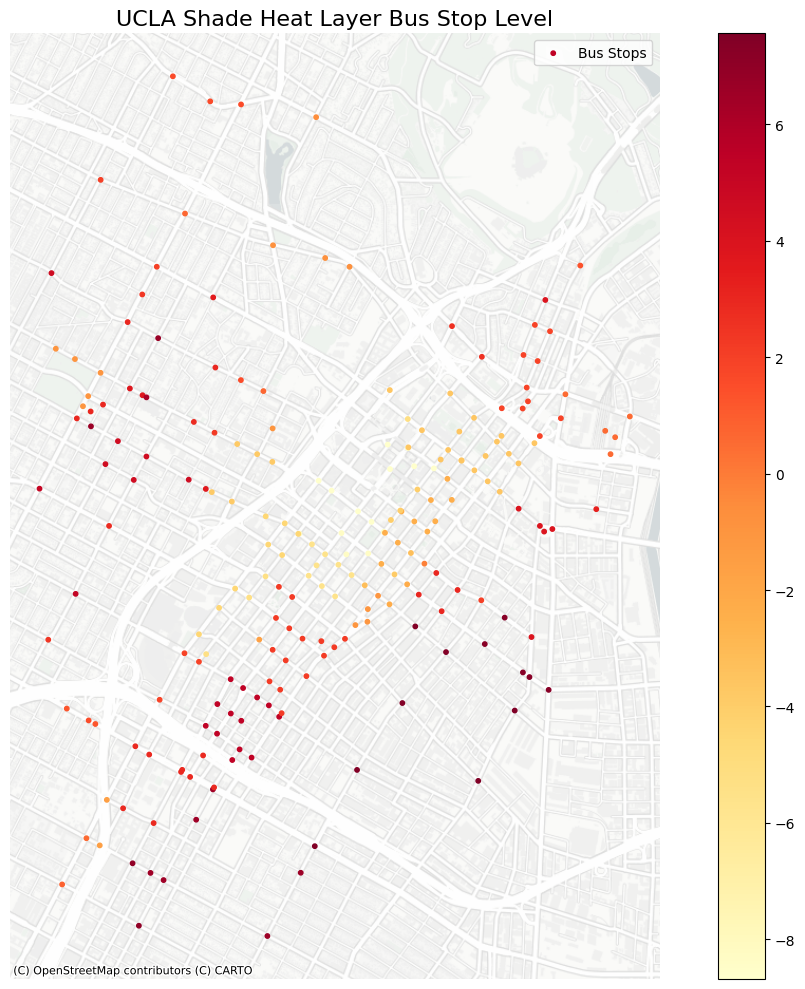

In [19]:
# This will do a join on all the bus stops with the polygon layers based on the intersection (the predicate)
target_variable = "heat_layer"
transit_stops_heat = gpd.sjoin(major_transit_stops_la, shade_reprojected, how = 'left') # make sure you join dataframes that are in the same projection

# Now we can visualize the excess number of er visits by bus stops, although since the aggregation 
# is a the zip code level, there won't be much variation

fig, ax = plt.subplots(figsize = (12, 10))

transit_stops_heat.plot(ax = ax, label = "Bus Stops", column = target_variable,cmap='YlOrRd', markersize = 10, legend = True)

# For this map let's turn off the axis and add LA as the background map
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = transit_stops_heat.crs)
# if you are interested in more background/basemaps you can see the full list with the command cx.providers

ax.set_axis_off()
ax.set_title('UCLA Shade Heat Layer Bus Stop Level', fontsize=16)


ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.legend()
plt.show()

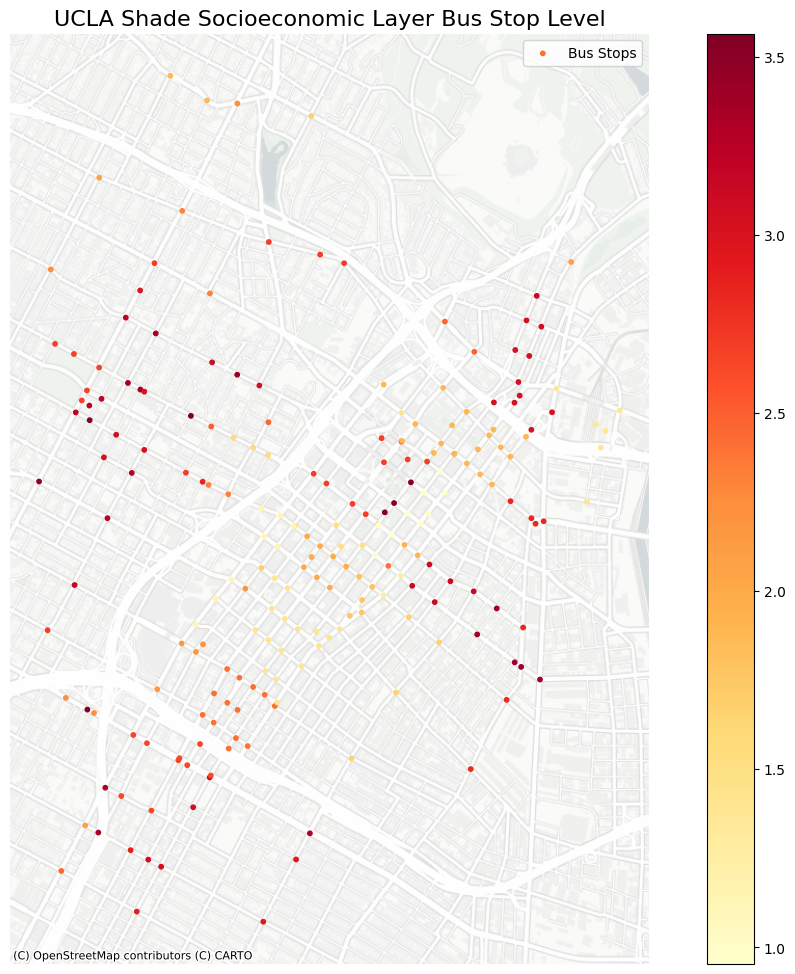

In [21]:
# This will do a join on all the bus stops with the polygon layers based on the intersection (the predicate)
target_variable = "socioeconomic_layer"
transit_stops_socio = gpd.sjoin(major_transit_stops_la, shade_reprojected, how = 'left') # make sure you join dataframes that are in the same projection

# Now we can visualize the excess number of er visits by bus stops, although since the aggregation 
# is a the zip code level, there won't be much variation

fig, ax = plt.subplots(figsize = (12, 10))

transit_stops_socio.plot(ax = ax, label = "Bus Stops", column = target_variable,cmap='YlOrRd', markersize = 10, legend = True)

# For this map let's turn off the axis and add LA as the background map
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = transit_stops_socio.crs)
# if you are interested in more background/basemaps you can see the full list with the command cx.providers

ax.set_axis_off()
ax.set_title('UCLA Shade Socioeconomic Layer Bus Stop Level', fontsize=16)


ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.legend()
plt.show()